In [27]:
# We will create a speech sentiment analyser with the help of Lstms and Speech Recognizer library
import numpy as np 
import pandas as pd 
from sklearn.feature_extraction.text import CountVectorizer
import featuretools
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer , PorterStemmer
import re
from nltk.corpus import stopwords
from keras.models import Sequential
from string import punctuation
import seaborn as sns
import matplotlib.pyplot as plt
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

Only keeping the necessary columns.

In [28]:
data = pd.read_csv('Sentiment.csv')
data = data[['text','sentiment']]

In [29]:
data.head()

,text,sentiment
0,RT @NancyLeeGrahn: How did everyone feel about...,Neutral
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive
2,RT @TJMShow: No mention of Tamir Rice and the ...,Neutral
3,RT @RobGeorge: That Carly Fiorina is trending ...,Positive
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,Positive


In [30]:
def clean(text, stem_words=True):
    import re
    from string import punctuation
    from nltk.stem import SnowballStemmer
    from nltk.corpus import stopwords
    
    def pad_str(s):
        return ' '+s+' '
    
    if pd.isnull(text):
        return ''

    
    if type(text) != str or text=='':
        return ''

    # Clean the text
    text = re.sub("\'s", " ", text) # we have cases like "Sam is" or "Sam's" (i.e. his) these two cases aren't separable, I choose to compromise are kill "'s" directly
    text = re.sub(" whats ", " what is ", text, flags=re.IGNORECASE)
    text = re.sub("\'ve", " have ", text)
    text = re.sub("can't", "can not", text)
    text = re.sub("n't", " not ", text)
    text = re.sub("i'm", "i am", text, flags=re.IGNORECASE)
    text = re.sub("\'re", " are ", text)
    text = re.sub("\'d", " would ", text)
    text = re.sub("\'ll", " will ", text)
    text = re.sub("e\.g\.", " eg ", text, flags=re.IGNORECASE)
    text = re.sub("b\.g\.", " bg ", text, flags=re.IGNORECASE)
    text = re.sub("(\d+)(kK)", " \g<1>000 ", text)
    text = re.sub("e-mail", " email ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?U\.S\.A\.", " America ", text, flags=re.IGNORECASE)
    text = re.sub("(the[\s]+|The[\s]+)?United State(s)?", " America ", text, flags=re.IGNORECASE)
    text = re.sub("\(s\)", " ", text, flags=re.IGNORECASE)
    text = re.sub("[c-fC-F]\:\/", " disk ", text)    
    text = re.sub('(?<=[0-9])\,(?=[0-9])', "", text)   
    text = re.sub('\$', " dollar ", text)
    text = re.sub('\%', " percent ", text)
    text = re.sub('\&', " and ", text)
    text = re.sub('[^\x00-\x7F]+', pad_str(SPECIAL_TOKENS['non-ascii']), text) 
    text = re.sub("(?<=[0-9])rs ", " rs ", text, flags=re.IGNORECASE)
    text = re.sub(" rs(?=[0-9])", " rs ", text, flags=re.IGNORECASE)
   # clean text rules get from : https://www.kaggle.com/currie32/the-importance-of-cleaning-text
    text = re.sub(r" (the[\s]+|The[\s]+)?US(A)? ", " America ", text)
    text = re.sub(r" UK ", " England ", text, flags=re.IGNORECASE)
    text = re.sub(r" india ", " India ", text)
    text = re.sub(r" switzerland ", " Switzerland ", text)
    text = re.sub(r" china ", " China ", text)
    text = re.sub(r" chinese ", " Chinese ", text) 
    text = re.sub(r" imrovement ", " improvement ", text, flags=re.IGNORECASE)
    text = re.sub(r" intially ", " initially ", text, flags=re.IGNORECASE)
    text = re.sub(r" quora ", " Quora ", text, flags=re.IGNORECASE)
    text = re.sub(r" dms ", " direct messages ", text, flags=re.IGNORECASE)  
    text = re.sub(r" demonitization ", " demonetization ", text, flags=re.IGNORECASE) 
    text = re.sub(r" actived ", " active ", text, flags=re.IGNORECASE)
    text = re.sub(r" kms ", " kilometers ", text, flags=re.IGNORECASE)
    text = re.sub(r" cs ", " computer science ", text, flags=re.IGNORECASE) 
    text = re.sub(r" upvote", " up vote", text, flags=re.IGNORECASE)
    text = re.sub(r" iPhone ", " phone ", text, flags=re.IGNORECASE)
    text = re.sub(r" \0rs ", " rs ", text, flags=re.IGNORECASE)
    text = re.sub(r" calender ", " calendar ", text, flags=re.IGNORECASE)
    text = re.sub(r" ios ", " operating system ", text, flags=re.IGNORECASE)
    text = re.sub(r" gps ", " GPS ", text, flags=re.IGNORECASE)
    text = re.sub(r" gst ", " GST ", text, flags=re.IGNORECASE)
    text = re.sub(r" programing ", " programming ", text, flags=re.IGNORECASE)
    text = re.sub(r" bestfriend ", " best friend ", text, flags=re.IGNORECASE)
    text = re.sub(r" dna ", " DNA ", text, flags=re.IGNORECASE)
    text = re.sub(r" III ", " 3 ", text)
    text = re.sub(r" banglore ", " Banglore ", text, flags=re.IGNORECASE)
    text = re.sub(r" J K ", " JK ", text, flags=re.IGNORECASE)
    text = re.sub(r" J\.K\. ", " JK ", text, flags=re.IGNORECASE)
    
    # replace the float numbers with a random number, it will be parsed as number afterward, and also been replaced with word "number"
    
    text = re.sub('[0-9]+\.[0-9]+', " 87 ", text)
  
    
    # Remove punctuation from text
    text = ''.join([c for c in text if c not in punctuation]).lower()
       # Return a list of words
    return text
SPECIAL_TOKENS = {
    'quoted': 'quoted_item',
    'non-ascii': 'non_ascii_word',
    'undefined': 'something'
}
data["text"] = data["text"].apply(clean)

In [31]:
data = data[data.sentiment != "Neutral"]
print(data[ data['sentiment'] == 'Positive'].size)
print(data[ data['sentiment'] == 'Negative'].size)
for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ')    
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)

4472
16986


In [32]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 29, 128)           256000    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 29, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 394       
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None


Hereby I declare the train and test dataset.

In [33]:
Y = pd.get_dummies(data['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(8583, 29) (8583, 2)
(2146, 29) (2146, 2)


In [34]:
batch_size = 32
model.fit(X_train, Y_train, epochs = 20, batch_size=batch_size, verbose = 2)

Epoch 1/20
 - 9s - loss: 0.4269 - acc: 0.8198
Epoch 2/20
 - 8s - loss: 0.3188 - acc: 0.8648
Epoch 3/20
 - 8s - loss: 0.2789 - acc: 0.8876
Epoch 4/20
 - 7s - loss: 0.2621 - acc: 0.8929
Epoch 5/20
 - 8s - loss: 0.2326 - acc: 0.9057
Epoch 6/20
 - 8s - loss: 0.2117 - acc: 0.9115
Epoch 7/20
 - 7s - loss: 0.1944 - acc: 0.9215
Epoch 8/20
 - 8s - loss: 0.1798 - acc: 0.9286
Epoch 9/20
 - 8s - loss: 0.1718 - acc: 0.9286
Epoch 10/20
 - 8s - loss: 0.1600 - acc: 0.9352
Epoch 11/20
 - 8s - loss: 0.1479 - acc: 0.9398
Epoch 12/20
 - 8s - loss: 0.1415 - acc: 0.9414
Epoch 13/20
 - 8s - loss: 0.1318 - acc: 0.9452
Epoch 14/20
 - 8s - loss: 0.1249 - acc: 0.9487
Epoch 15/20
 - 8s - loss: 0.1239 - acc: 0.9515
Epoch 16/20
 - 8s - loss: 0.1143 - acc: 0.9536
Epoch 17/20
 - 8s - loss: 0.1095 - acc: 0.9542
Epoch 18/20
 - 8s - loss: 0.1110 - acc: 0.9565
Epoch 19/20
 - 8s - loss: 0.1061 - acc: 0.9576
Epoch 20/20
 - 8s - loss: 0.0968 - acc: 0.9605


Extracting a validation set, and measuring score and accuracy.

In [35]:
# Here we are creating a validation set to test how good our model is
validation_size = 1500
X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

score: 0.82
acc: 0.83


In [36]:
pos_tot, neg_tot , pos_correct, neg_correct = 0, 0, 0, 0


for x in range(len(X_validate)):
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1  
    if np.argmax(Y_validate[x]) == 0:
        neg_tot += 1
    else:
        pos_tot += 1

print("positive accuracy of the model", pos_correct/pos_cnt*100, "%")
print("negative accuracy of the model", neg_correct/neg_cnt*100, "%")
print("Total_accuracy is", (pos_correct + neg_correct)/(pos_cnt + neg_cnt)*100,"")

positive accuracy of the model 50.33557046979866 %
negative accuracy of the model 92.09650582362728 %
Total_accuracy is 83.8 


The above predictions are more accurate for negative results because there is more training data for negative tweets but there is not much data for positive tweets to be trained.

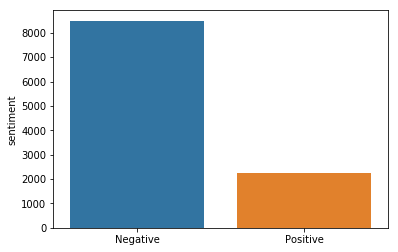

In [37]:
sns.barplot(x=data.sentiment.value_counts().index, y=data.sentiment.value_counts())

In [26]:
import speech_recognition as sr
r = sr.Recognizer()
with sr.Microphone() as source:
    print("Speak  :")
    audio = r.listen(source)
    text = r.recognize_google(audio)
    print("I said- " +text)
    text2=list(text)
    print(type(text))
    text2[0 : len(text)+1] = [''.join(text2[0 : len(text)+1])]
    print(text2)
    twt = tokenizer.texts_to_sequences(text2)
    twt = pad_sequences(twt, maxlen=29, dtype='int32', value=0)
    print(twt)
    sentiment = model.predict(twt,batch_size=1,verbose = 2)[0]
    if(np.argmax(sentiment) == 0):
        print("negative")
    elif (np.argmax(sentiment) == 1):
        print("positive")     

        

Speak  :
I said- I hate the way you are angry all the time
<class 'str'>
['I hate the way you are angry all the time']
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0   10  366    1  267   14   23 1190   51    1
   110]]
negative
